# Formula 1 Radio Sentiment Analysis with Bert

In this notebook, two BERT models are implemented:

1. First one is a **trained BERT from sratch**.
2. Secondly, a **pre-trained BERT model** will be downloaded and fine-tuned with my team radios.

After some research, I decided to **not implement the first point**. Here is the explanation:

---

## Sentiment Analysis for F1 Radio Messages: RoBERTa-base with Fine-tuning

### Why RoBERTa-base?

RoBERTa-base is our selected model for sentiment analysis of Formula 1 radio communications for the following reasons:

1. **Superior performance on sentiment classification**: RoBERTa consistently outperforms BERT in emotion detection tasks due to its improved training methodology and longer pretraining.

2. **Strong contextual understanding**: F1 radio messages contain technical jargon, specialized terminology, and driver/team codes that require deep semantic understanding to interpret correctly.

3. **Effective with specialized communications**: F1 radio messages typically feature:
   - Short, direct communications with minimal context
   - Technical terminology and abbreviations (e.g., "box this lap", "DRS enabled")
   - High-pressure communications with non-standard sentence structures
   - Team-specific codes and references

4. **Better handling of domain-specific language**: RoBERTa's robust pretraining makes it more adaptable to specialized domains like motorsport communications.

---

### Why Fine-tuning Instead of Training from Scratch?

Training RoBERTa from scratch is impractical for our project due to:

- **Dataset size limitation**: Our dataset contains only 530 labeled examples, whereas training from scratch would require millions of examples (RoBERTa was pre-trained on ~160GB of text).

- **Computational requirements**: Training RoBERTa-base from scratch would require:
  - 8+ high-end GPUs (NVIDIA V100/A100).
  - 1-2 weeks of continuous training.
  - Approximately 200-400GB of GPU memory.
  - Estimated cost: $5,000-$10,000 on cloud providers.

- **Transfer learning advantage**: Fine-tuning leverages knowledge already encoded in pre-trained weights, requiring only ~2-4 hours on a single GPU to adapt to our F1 domain.

By fine-tuning RoBERTa-base, we can achieve excellent performance while utilizing the model's pre-existing understanding of language structure and sentiment, which is particularly valuable given our specialized domain and limited labeled data.

In [ ]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
import datetime


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

### Loading the RoBERTa model and also the tokenizer.

First, we need to download the RoBERTa model, with its correspondant tokenizer.

In [25]:
# Cell 2: Download the RoBERTa model and tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Assuming we have positive, negative, and neutral sentiments
    output_attentions=False,
    output_hidden_states=False,
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Move model to the appropriate device (GPU if available)
model.to(device)
print(f"Model {model_name} loaded successfully")

Model roberta-base loaded successfully


--- 

#### Loading and preparing the data

In [27]:
# Cell 3: Load and prepare the data
# Load the CSV file
df = pd.read_csv('../../outputs/week4/radio_clean/radio_labeled_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())



Dataset shape: (530, 3)

First few rows:
   driver                                      radio_message sentiment
0       1  So don't forget Max, use your head please. Are...   neutral
1       1  Okay Max, we're expecting rain in about 9 or 1...   neutral
2       1  You might find this lap that you meet a little...   neutral
3       1  Just another two or three minutes to get throu...   neutral
4       1   So settle into standard race management now Max.   neutral


In [28]:
# Check sentiment distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Sentiment distribution:
sentiment
neutral     379
negative    101
positive     50
Name: count, dtype: int64


--- 
### Creating numeric variables.

I need to change the labelling to numeric labels, basing myself on numeric values. The next correlation will be made:

1. *Positive* will become a 0.
2. *Neutral* will become a 1.
3. *Negative* will become a 2.

In [29]:
# Create numeric labels based on sentiment values
sentiment_mapping = {
    'positive': 0, 
    'neutral': 1, 
    'negative': 2
}

# Apply mapping (adjust this based on your actual sentiment values)
df['label'] = df['sentiment'].map(sentiment_mapping)

# Check if we need to handle any missing mappings
if df['label'].isna().sum() > 0:
    print(f"\nWarning: {df['label'].isna().sum()} rows couldn't be mapped. Unique values in 'sentiment':")
    print(df['sentiment'].unique())


---

### Creating the training, validation and test split.

I´ll follow the same splits techniques during the project, making a training, validation and test dataset.

* *Train* will be 70% of the dataset.
* *Validation*: will be 15% of the dataset.
* *Test*: will be 15% of the dataset.

In [30]:
# Cell 4: Create the train/validation/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['radio_message'].values, 
    df['label'].values, 
    test_size=0.3,  # 30% for val+test
    random_state=42, 
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 50% of the 30% (so 15% of total)
    random_state=42,
    stratify=temp_labels
)


In [31]:
print(f"Training set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")

Training set: 371 samples
Validation set: 79 samples
Test set: 80 samples


---

## Next Step: Tokenizing



### Knowing the max lenght for adjusting tokenizing

The next cell calculates the 97th percentile for knowing the average tokens of the radios. With this, I can establish a good max lenght for tokenizing without truncating almost any message.

---

In [32]:
# Cell 4.5: Analyze message lengths to set appropriate max_length
def get_token_counts(texts):
    # Count tokens in each message
    token_counts = [len(tokenizer.encode(text)) for text in texts]
    return token_counts

token_counts = get_token_counts(df['radio_message'].values)

# Calculate statistics
avg_tokens = sum(token_counts) / len(token_counts)
max_tokens = max(token_counts)
p97_tokens = np.percentile(token_counts, 97)  # 97th percentile

print(f"Average tokens per message: {avg_tokens:.1f}")
print(f"Maximum tokens in a message: {max_tokens}")
print(f"97% of messages have {p97_tokens:.1f} tokens or fewer")



Average tokens per message: 26.5
Maximum tokens in a message: 326
97% of messages have 79.4 tokens or fewer


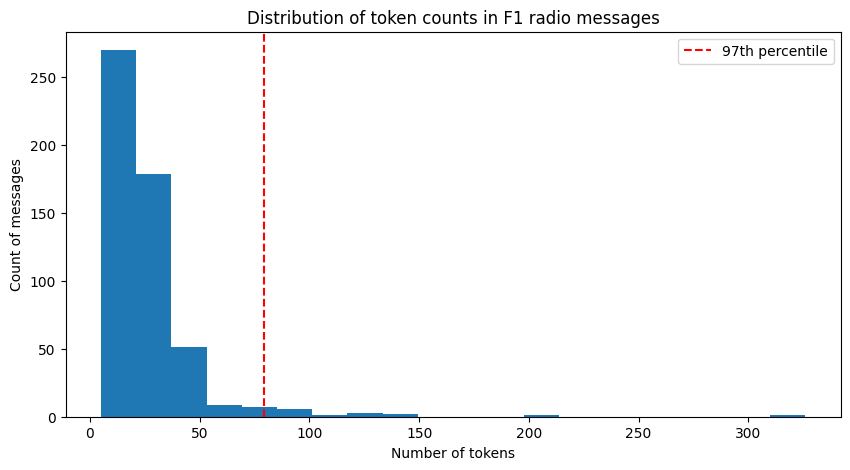

Setting max_length to 128


In [33]:
# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20)
plt.axvline(x=p97_tokens, color='r', linestyle='--', label='97th percentile')
plt.xlabel('Number of tokens')
plt.ylabel('Count of messages')
plt.title('Distribution of token counts in F1 radio messages')
plt.legend()
plt.show()

# Set max_length based on analysis
max_length = int(min(128, 2 * p97_tokens))  # Conservative value based on 97th percentile
print(f"Setting max_length to {max_length}")

--- 

### No I can proceed to tokenize the text

In [34]:
# Cell 5: Tokenize the data directly
max_length = 128
batch_size = 16

# Tokenize training data
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize validation data
val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize test data
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)



--- 

### Preparing the tokens for Pytorch: Pipeline.

1. **Convert labels to tensors**: Transform NumPy/list labels into PyTorch tensors required for neural network operations.

2. **Create TensorDatasets**: Combine input_ids (tokenized text), attention_mask (identifies real tokens vs padding), and labels into unified dataset objects.

3. **Define DataLoaders**: Configure batch processing with specified batch size, enabling shuffling for training data and efficient memory management.

In [35]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [36]:
# Create TensorDatasets
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)



In [37]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created DataLoaders with batch size: {batch_size}")
print(f"Each batch contains: {next(iter(train_dataloader))[0].shape[0]} samples")
print(f"Input shape: {next(iter(train_dataloader))[0].shape}")

Created DataLoaders with batch size: 16
Each batch contains: 16 samples
Input shape: torch.Size([16, 128])


---

## Set up training process


### Why 4 Epochs for Fine-tuning?

Four epochs is typically optimal for RoBERTa fine-tuning for several key reasons:

1. **Pretrained Knowledge**: RoBERTa already contains extensive language understanding from pretraining, so it requires fewer epochs to adapt to new tasks.

2. **Small Dataset Considerations**: With only 530 samples, training for too many epochs would lead to overfitting where the model memorizes training examples rather than learning generalizable patterns.

3. **Empirical Evidence**: Research indicates that transformer models typically reach peak performance on downstream tasks within 2-5 epochs, with diminishing or negative returns thereafter.

4. **Resource Efficiency**: Each epoch with RoBERTa is computationally expensive, so limiting to 4 epochs optimizes training time while maintaining performance.

5. **Learning Rate Schedule**: Our linear warmup and decay schedule is designed for a short fine-tuning process of approximately 3-5 epochs.

If you want to optimize further, you could implement early stopping based on validation performance, but 4 epochs generally provides a good balance of adaptation and generalization for sentiment analysis tasks.


In [38]:
# Cell 6: Set up training parameters and optimizer
# Training hyperparameters
epochs = 4
warmup_steps = 0
learning_rate = 2e-5
weight_decay = 0.01

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Initialize optimizer
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  eps=1e-8,
                  weight_decay=weight_decay)

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps=warmup_steps,
                                           num_training_steps=total_steps)

print(f"Optimizer and scheduler configured for {epochs} epochs")

Optimizer and scheduler configured for 4 epochs


c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


---

### Defining helper functions

In [ ]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# For timing
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

---

### Set up the training 

In [ ]:
seed_val = 42
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

# Storage for stats
training_stats = []
best_val_accuracy = 0.0

print(f"Starting training for {epochs} epochs")
print(f"Training on {len(train_dataloader) * batch_size} samples")
print(f"Validating on {len(val_dataloader) * batch_size} samples")

Starting training for 4 epochs
Training on 384 samples
Validating on 80 samples


--- 

## Training loop

In [ ]:
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\nEpoch {epoch_i + 1}/{epochs}")
    
    # Training
    model.train()
    total_train_loss = 0
    t0 = time.time()
    
    for batch in train_dataloader:
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Clear gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(
            b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )
        
        # Get loss and update total
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Backward pass and update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Training loss: {avg_train_loss:.4f}")
    print(f"  Training time: {format_time(time.time() - t0)}")

---

## Validation Loop


In [ ]:
# Switch to evaluation mode
model.eval()
val_accuracy = 0
val_loss = 0

# No gradient calculation needed for validation
with torch.no_grad():
    for batch in val_dataloader:
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Forward pass
        outputs = model(
            b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )
        
        # Get loss and predictions
        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate metrics
        val_loss += loss.item()
        val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())

# Calculate averages
avg_val_accuracy = val_accuracy / len(val_dataloader)
avg_val_loss = val_loss / len(val_dataloader)

print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
print(f"  Validation loss: {avg_val_loss:.4f}")

# Store stats
training_stats.append({
    'epoch': epoch_i + 1,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'val_accuracy': avg_val_accuracy
})

# Save best model
if avg_val_accuracy > best_val_accuracy:
    best_val_accuracy = avg_val_accuracy
    torch.save(model.state_dict(), 'best_roberta_sentiment_model.pt')
    print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")

print(f"Training complete! Total time: {format_time(time.time() - total_t0)}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")